In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols

pd.set_option('max_columns', None)
sns.set_theme(style="ticks")

# Linear Regression Model

In order to test the relevance of the selected features over the win percentage in NBA's regular season, I built and evaluated a multivariate linear regression model. In this notebook, I start by loading a CSV file with all the features extracted from the raw datasets in the `data_collection` and `data_cleaning_feature_engineering` notebooks and dropping the `Team_ID`, `TEAM_NAME`, and `YEAR` variables, leaving only the features potentially relevant to the model.

In [2]:
all_teams_full = pd.read_csv('all_teams_full_cleaned.csv')

In [3]:
all_features = all_teams_full.drop(columns=['TEAM_ID', 'TEAM_NAME', 'YEAR'])

In [56]:
all_features

,WIN_PCT,FG_PCT,REB,AST_TOV_RAT,PTS,OPP_PPG,HOME_WIN_PCT,PLAYOFF,TOP3_PPG,TOP3_P14,OFF_BENCH_PPG,BENCH_P30
0,0.439,0.471,44.5,1.514793,108.6,111.3,0.487805,1,18.032740,1,34.951220,1
1,0.354,0.480,43.2,1.465116,107.8,110.6,0.390244,0,18.894844,1,28.853659,0
2,0.378,0.470,44.8,1.182741,104.4,108.2,0.609756,0,17.705386,1,31.109756,1
3,0.512,0.490,40.3,1.440000,104.5,103.7,0.756098,1,16.714243,1,27.926829,0
4,0.695,0.502,42.8,1.714286,108.8,101.2,0.902439,1,18.791115,1,28.060976,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1105,0.622,0.471,47.8,1.805369,115.2,112.5,0.756098,1,20.830769,1,23.475610,0
1106,0.589,0.468,45.4,1.816901,110.7,108.4,0.885714,1,19.672070,1,37.109756,1
1107,0.681,0.476,45.1,1.645833,113.6,108.1,0.805556,1,20.753404,1,38.341463,1
1108,0.622,0.466,42.3,1.896000,109.9,107.3,0.585366,1,21.757569,1,28.048780,0


### Field Definitions

`WIN_PCT`:       Wining percentage
`FG_PCT`:        Field Goal Percentage
`REB`:           Number of Rebounds per Game
`AST_TOV_RAT`:   Assistance/Turnover Ratio
`PTS`:           Average Points Per Game
`OPP_PPG`:       Average Opponent Points Per Game
`HOME_WIN_PCT`:  Percentage of Home Games Won
`PLAYOFF`:       Whether a Tean Classified to Playoffs a Given Year
`TOP3_PPG`:      Average Points Per Game by the Top 3 Scorers
`TOP3_P10`:      Whether the Top 3 Scorers All Averaged at Least 10 Points
`OFF_BENCH_PPG`: Average Points Per Game Off-The-Bench
`BENCH_P30`:     Whether a Team Averaged 30 plus Points Off-The-Bench per Game

### Correlation Matrix

Next is a Pearson Correlation matrix that shows how correlated variables are with each other. The most relevant row is the first, where we can assess the correlation between the variable I'm trying to predict and all the others. It's noticeable that `OFF_BENCH_PPG`, and `BENCH_P30` are not correlated to the win percentage, so I'm not using these. Furthermore, the average Top 3 players points per game, `TOP3_PPG` is much more correlated to the win percentage than it's boolean counterpart `TOP3_P10`, so I'm also not using `TOP3_P10`.

The `PPG` and `OPP_PPG` variables are highly correlated among themselves, violating the multicolinearity assumption for regression models, so only `OPP_PPG` will be used. `FG_PCT` is also highly correlated to other variables, so it will not be used.

In addition to that, `HOME_WIN_PCT`, the most correlated variable, is not interesting as a predictor for wining percentage since it accounts for half of the games represented by it. The `PLAYOFF` variable is also not relevant for the sake of this model.

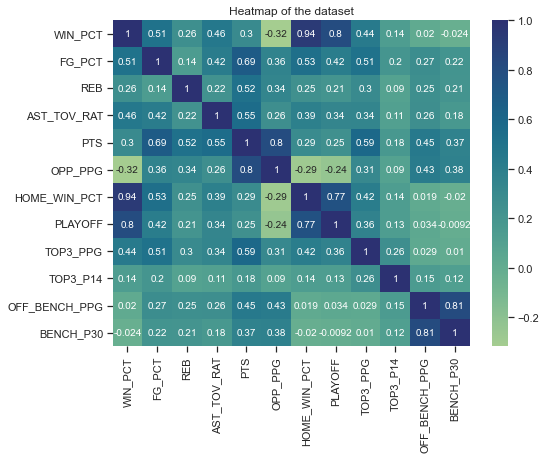

In [5]:
# Create a heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(
    all_features.corr(), 
    annot=True, 
    cmap="crest")
plt.title("Heatmap of the dataset")
plt.show()

Since the variable the model is trying to predict and some of the predictors are in a vastly different scale, I'm rescaling some of the variables by dividing it by $10^{2}$.

In [6]:
all_features_scaled = all_features.copy()

In [7]:
all_features_scaled['REB'] = all_features_scaled['REB']/100
all_features_scaled['PTS'] = all_features_scaled['PTS']/100
all_features_scaled['OPP_PPG'] = all_features_scaled['OPP_PPG']/100
all_features_scaled['TOP3_PPG'] = all_features_scaled['TOP3_PPG']/100
all_features_scaled['OFF_BENCH_PPG'] = all_features_scaled['OFF_BENCH_PPG']/100


In [8]:
all_features_scaled

,WIN_PCT,FG_PCT,REB,AST_TOV_RAT,PTS,OPP_PPG,HOME_WIN_PCT,PLAYOFF,TOP3_PPG,TOP3_P14,OFF_BENCH_PPG,BENCH_P30
0,0.439,0.471,0.445,1.514793,1.086,1.113,0.487805,1,0.180327,1,0.349512,1
1,0.354,0.480,0.432,1.465116,1.078,1.106,0.390244,0,0.188948,1,0.288537,0
2,0.378,0.470,0.448,1.182741,1.044,1.082,0.609756,0,0.177054,1,0.311098,1
3,0.512,0.490,0.403,1.440000,1.045,1.037,0.756098,1,0.167142,1,0.279268,0
4,0.695,0.502,0.428,1.714286,1.088,1.012,0.902439,1,0.187911,1,0.280610,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1105,0.622,0.471,0.478,1.805369,1.152,1.125,0.756098,1,0.208308,1,0.234756,0
1106,0.589,0.468,0.454,1.816901,1.107,1.084,0.885714,1,0.196721,1,0.371098,1
1107,0.681,0.476,0.451,1.645833,1.136,1.081,0.805556,1,0.207534,1,0.383415,1
1108,0.622,0.466,0.423,1.896000,1.099,1.073,0.585366,1,0.217576,1,0.280488,0


### Feature Selection

Finally, out of the original features, the selected ones to be used in the model are: `REB`, `AST_TOV_RAT`, `OPP_PPG`, and `TOP3_PPG`. I separated the data set into traning and testing sets using a `test_size` of 0.2, and StatsModels' Ordinary Least Squares model, `ols()`, was used to create the multivariate linear regression model.

In [48]:
# Separate data set into the predicted and predicting varibles
data_X = all_features_scaled[['REB','AST_TOV_RAT', 'OPP_PPG', 'TOP3_PPG']]
data_Y = all_features_scaled['WIN_PCT']

# Use train_test_split to create the training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_X, data_Y, 
                                                    test_size = 0.2, random_state = 7)

In [49]:
# Write out OLS formula as a string
ols_formula = "WIN_PCT ~ AST_TOV_RAT + REB + OPP_PPG + TOP3_PPG"

# Create OLS dataframe
ols_data = pd.concat([X_train, y_train], axis = 1)

# Create OLS object and fit the model
OLS = ols(formula = ols_formula, data = ols_data)
model = OLS.fit()

# Get model results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                WIN_PCT   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     425.2
Date:                Wed, 07 Feb 2024   Prob (F-statistic):          3.95e-204
Time:                        17:31:53   Log-Likelihood:                 885.94
No. Observations:                 888   AIC:                            -1762.
Df Residuals:                     883   BIC:                            -1738.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1101      0.064      1.717      0.086      -0.016       0.236
AST_TOV_RAT     0.3107      0.016     19.994      0.000       0.280       0.341
REB             1.9706      0.155     12.736      0.000       1.667       2.274
OPP_PPG        -1.3402      0.045    -29.680      0.000      -1.429      -1.252
TOP3_PPG        2.5056      0.137     18.246      0.000       2.236       2.775
==============================================================================
Omnibus:                        0.842   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.656   Jarque-Bera (JB):                0.728
Skew:                           0.061   Prob(JB):                        0.695
Kurtosis:                       3.069   Cond. No.                         120.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model Results

The resulting model has an adjusted R-Squared value of 0.65, which means the predicting variables account for 65% of the variation in the predicted variable. The coeficients read as the following:
- `AST_TOV_RAT`: For each 0.1 increase in the assistance/turnover ratio, the Wining Rate is expected to increase in 3.1%
- `REB`: For each Rebound Per Game increase, the Wining Rate is expected to increase in 1.9%
- `OPP_PPG`: For each Opponent Point Per Game increase, the Wining Rate is expected to decrease in 1.3%
- `TOP3_PPG`: For each point in the Point Per Game average among the Top 3 scorers, the Wining Rate is expected to increase in 2.5%

### Model Assessment

Checking for linear regression models assumptions:
- Linear relationship
- Multivariate Normality
- No Multicolinearity
- Homoscedasticity
- Normaly Distributed Residuals

#### Linear Relationship, Multivariate Normality, and No Multicolinearity

The chart below shows a scatterplot between each pair of variables and a histogram for each variable. From this chart we can confirm the first three linear regression model assumptions:
1) The predictor variables are linearly correlated to the predicted variable and have weak to moderate correlation.
2) The predictor variables are not correlated to each other.
3) Each of the predictor variables follows a normal distribution.

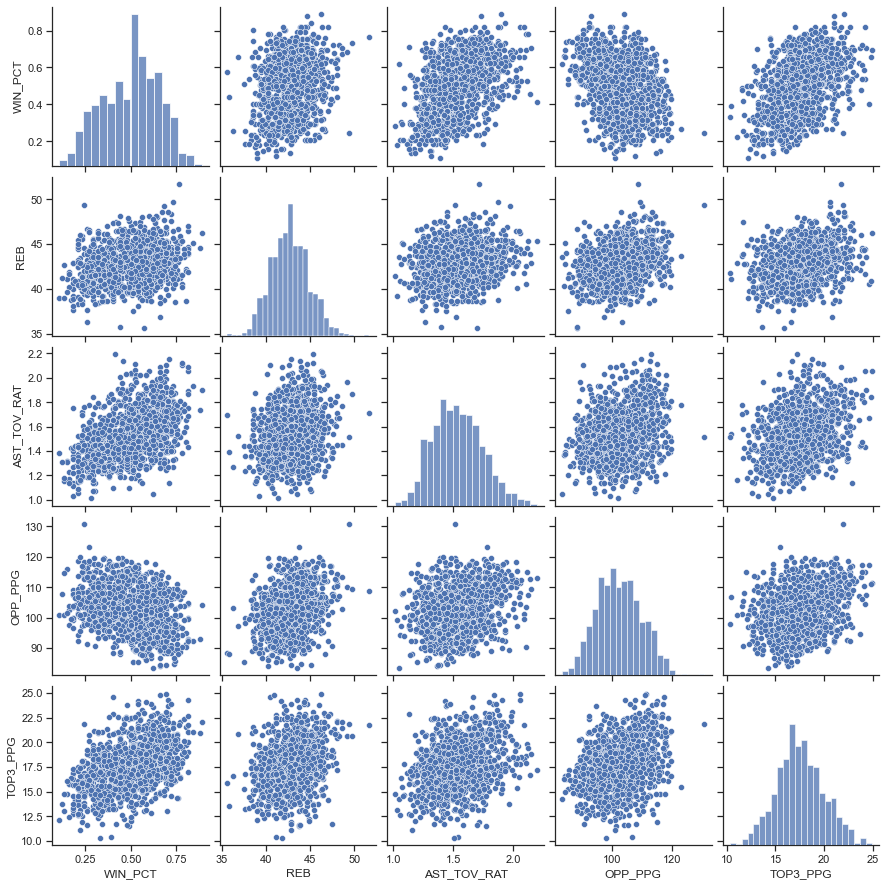

In [51]:
fig = sns.pairplot(all_features[['WIN_PCT', 'REB','AST_TOV_RAT', 'OPP_PPG', 'TOP3_PPG']])
plt.show()

#### Homoscedasticity, Normal Distribution of Residuals

The following charts account for the other model assumptions:
1) Homoscedasticity: the residuals are randomly distributed.
2) The residuals follow a normal distribution.

In [52]:
fitted_values = model.predict(X_test)
residuals = fitted_values - y_test

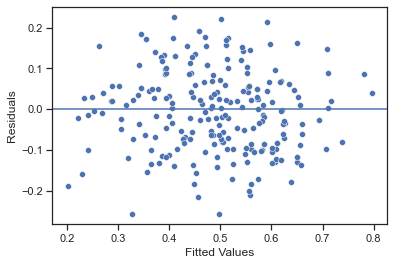

In [53]:
# Create a scatterplot of residuals against fitted values

fig = sns.scatterplot(x=fitted_values, y=residuals)
fig.axhline(0)
fig.set_xlabel("Fitted Values")
fig.set_ylabel("Residuals")
plt.show()

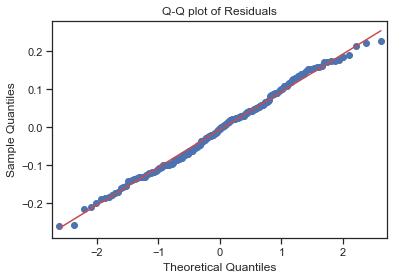

In [54]:
import statsmodels.api as sm
sm.qqplot(residuals, line='s')
plt.title("Q-Q plot of Residuals")
plt.show()

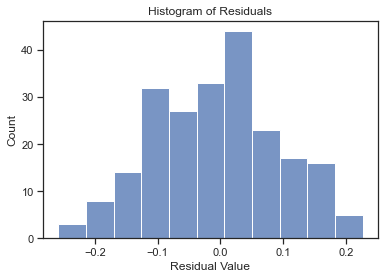

In [55]:
fig = sns.histplot(residuals)
fig.set_xlabel("Residual Value")
fig.set_title("Histogram of Residuals")
plt.show()